# Tutorial 5 - Objective numerical aperture

Welcome to the fifth tutorial of this series!
In this notebook, we'll investigate the effect of the objective numerical aperture on the structure function.
This allows us to extend the range of wave vectors that can be analyzed with DDM to **higher** values.

### Purpose

The goal of this tutorial is to demonstrate the effect of the objective numerical aperture on the results obtained by DDM.
Specifically, we will:

0. Set up the workspace and import the libraries
    1. Set up the workspace.
    2. Give an overview of the sample under investigation.
    3. Import libraries.
1. Compute the structure function of image sequences using DDM.
    1. Load the image sequences and see the effect of different objective numerical apertures on the input images.
    2. Calculate the corresponding structure functions.
    3. Calculate the azimuthal averages.
2. Fit the azimuthal average to gain insights into the sample's dynamics.
    1. Estimate the parameters.
    2. Fit the data using a diffusive dynamics model.
    3. Observe the effect of the objective numerical aperture on the limits of the technique.
    4. Fit the parameters obtained from the fit to the data to retrieve the diffusion coefficient of the particles.

This tutorial assumes that you have a basic understanding of the features offered by fastDDM. If you need a refresher, consider reviewing the ["zeroth" tutorial](../Tutorial_0-Introduction/tutorial0.ipynb).
It also builds on top of the previous tutorials [1](../Tutorial_1-Particle_sizing/tutorial1.ipynb) and [2](../Tutorial_2-Melt/tutorial2.ipynb).

At the end of the notebook, there will be an optional (starred) section:

* (*): Figures for the objective numerical aperture section of the paper.

## 0. Initial setup

### 0.A. Setting up your workspace

Before we dive into the analysis, make sure you have **fastDDM** and the required scientific analysis, fitting, and visualization packages installed on your machine. Refer to the main [README](../README.md) for installation instructions.

For this tutorial, we'll be using custom microscopy videos acquired for these tutorials.
If you haven't done so already, download the files (the `DATASET` folder) in the directory containing these tutorials.

Your main directory tree should resemble the following:
```
.
├── DATASET
│   └── ...
├── Tutorial_5-Objective_na
└── ...
```

### 0.B. Sample description and experimental parameters

The sample under study consists of a dilute solution of polystyrene spheres (PS, nominal diameter 252 nm, Microparticles GmbH) dispersed in a glycerol aqueous solution ($c_{\text{gly}} = 21.5\%$) to prevent sedimentation.
The sample was prepared at a volume fraction $\phi=10^{-3}$ and loaded into a 0.3 $\times$ 3 $\times$ 50 mm glass capillary (Vitrocom).
The experiments were performed at $T \simeq 21^{\circ}\mathrm{C}$ (solvent viscosity $\eta = 1.78 \, \mathrm{mPa \, s}$).

The videos were acquired at 108 and 1 fps for the fast and slow acquisition, respectively, using a Nikon Eclipse Ti2 inverted microscope equipped with a Prime BSI Express CMOS camera (pixel size $6.5 \, \mathrm{µm}$).
Each set of videos was acquired using objectives with different numerical apertures and two different magnifications:
* 20$\times$, NA 0.45
* 20$\times$, NA 0.7
* 60$\times$, NA 0.7
* 60$\times$, NA 1.27

The effective pixel size is calculated according to $\delta_{px} = 6.5/m_o \, \mathrm{µm}$, where $m_o$ is the objective magnification.
This gives 325 nm for the 20$\times$ objectives and 108 nm for the 60$\times$ ones.
The image sequences are composed of 10000 frames each, 256$\times$256 pixels.

### 0.C. Let's get started

Let's import some essential libraries, including `fastDDM`.

In [1]:
%matplotlib notebook

import gc
import os
import lmfit
import numpy as np

# set numpy print options to limit the length of the output
np.set_printoptions(threshold=0)

# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredText

# get rid of the 'too many open images' warning
mpl.rcParams.update({'figure.max_open_warning': 0})

# color space helper
def color_space( 
    length: int,
    colormap: cm.colors.LinearSegmentedColormap = cm.viridis,
    vmin: float = 0.2, 
    vmax: float = 1.0
) -> np.ndarray:
    return colormap(np.linspace(vmin, vmax, length))

# fastddm
import fastddm as fd
from fastddm.fit import fit

Here, we define the paths to the videos and the labels.

In [2]:
# directory containing the videos
main_directory = '../DATASET/'

# high frame rate videos file names (including enclosing folder)
file_names_fast = [
    'PS_252nm_phi_1e-3_20x_NA_0-45/fast.nd2',
    'PS_252nm_phi_1e-3_20x_NA_0-7/fast.nd2',
    'PS_252nm_phi_1e-3_60x_NA_0-7/fast.nd2',
    'PS_252nm_phi_1e-3_60x_NA_1-27/fast.nd2',
]

# create full paths
file_paths_fast = [
    os.path.join(main_directory, fn) for fn in file_names_fast
]

# low frame rate videos file names (including enclosing folder)
file_names_slow = [
    'PS_252nm_phi_1e-3_20x_NA_0-45/slow.nd2',
    'PS_252nm_phi_1e-3_20x_NA_0-7/slow.nd2',
    'PS_252nm_phi_1e-3_60x_NA_0-7/slow.nd2',
    'PS_252nm_phi_1e-3_60x_NA_1-27/slow.nd2',
]

# create full paths
file_paths_slow = [
    os.path.join(main_directory, fn) for fn in file_names_slow
]

# list of labels
labels = [
    r'20x, NA$_o$ 0.45',
    r'20x, NA$_o$ 0.7',
    r'60x, NA$_o$ 0.7',
    r'60x, NA$_o$ 1.27',
]

## 1. Structure function calculation

### 1.A. Load and visualize images

As usual, we start by inspecting the image sequences.
We show the first frame of the fast videos side by side.

<IPython.core.display.Javascript object>


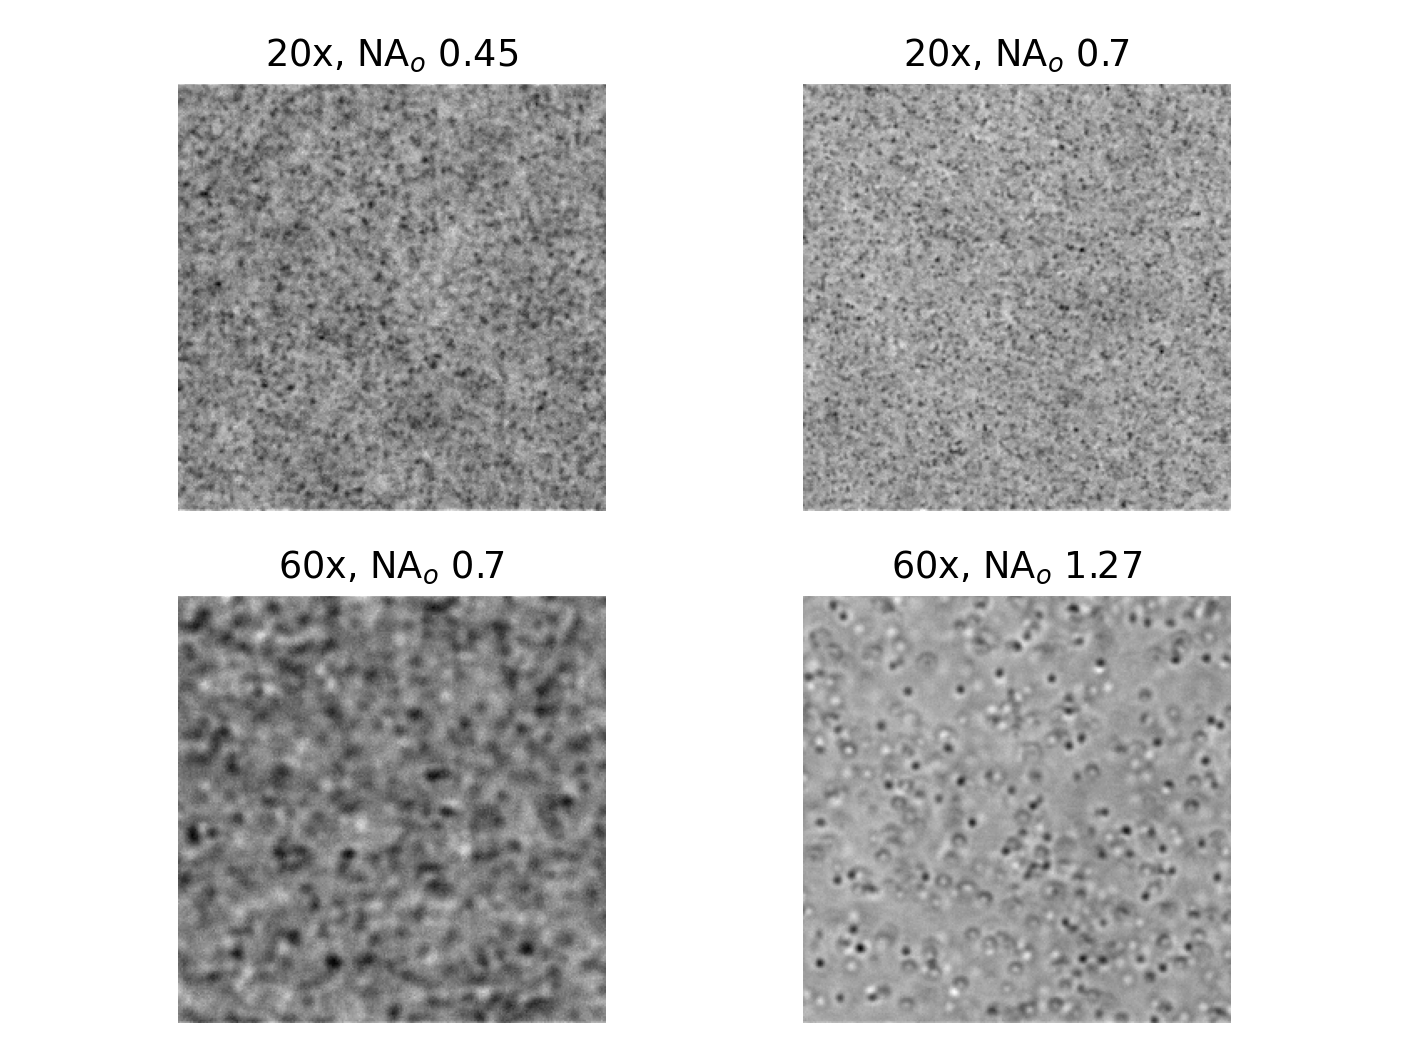

In [3]:
fig = plt.figure()
gs = fig.add_gridspec(ncols=2, nrows=2)
axs = gs.subplots()

# read the images
images = [fd.read_images(fp, seq=[0])[0] for fp in file_paths_fast]
images = np.array(images)

for ax, img, label in zip(axs.flatten(), images, labels):
    ax.imshow(img, cmap='gray')
    
    ax.set_axis_off()
    ax.set_title(label)

fig.tight_layout();

Compared to what we observed in [tutorial4](../Tutorial_4-Objective_magnification/tutorial4.ipynb), while the objective magnification allows us to zoom in, increasing the numerical aperture increases the level of details we see in the image.

### 1.B-C. Structure function and azimuthal average calculation

The process here mirrors the one outlined in [tutorial2](../Tutorial_2-Melt/tutorial2.ipynb).
Use the following cell to select the `core` and `mode` you wish to use for the calculation of the structure function.

In [4]:
### UNCOMMENT THE CORE YOU WISH TO USE ###
CORE = 'py'
#CORE = 'cpp'
#CORE = 'cuda'

### UNCOMMENT THE MODE YOU WISH TO USE ###
#MODE = 'diff'
MODE = 'fft'

Here, we set the experimental parameters of the acquisition.

In [5]:
# experimental acquisition parameters
magnifications = [20, 20, 60, 60]
pixel_size = [6.5 / mag for mag in magnifications]  # microns per pixel

frame_rate_fast = 108    # frames per second
frame_rate_slow = 1      # frames per second

Finally, we separately compute the structure function and the azimuthal averages for the two acquisitions. For each pair of azimuthal averages, we compute the melt, which we will keep for the analysis.

In [6]:
print('--- Calculating structure functions and azimuthal averages... ---')

# initialize list of azimuthal averages
aa = []

for num, (fpathf, fpaths) in enumerate(zip(file_paths_fast,
                                           file_paths_slow)):
    # analyze fast acquisition
    # notify user on progress
    print(f'Analyzing fast movie #{num+1} of {len(file_paths_fast)} ...')
    
    # read image sequence
    img_seq = fd.read_images(fpathf)
    
    # compute structure function
    # we analyze delays only up to half the length of the video
    lags = range(1, int(len(img_seq) / 2))
    dqt = fd.ddm(img_seq, lags, core=CORE, mode=MODE)
    
    # set pixel size and time delay
    dqt.pixel_size = pixel_size[num]
    dqt.set_frame_rate(frame_rate_fast)
    
    # compute azimuthal average
    bins = int(len(dqt.ky) / 2)                     # number of bins
    bin_range = (0, dqt.ky[-1])                     # bin range
    ccm = fd.mask.central_cross_mask(dqt.shape[1:]) # mask for central cross
    
    aa_fast = fd.azimuthal_average(dqt, bins=bins, range=bin_range,
                                   mask=ccm)
    
    # delete unused variables
    del img_seq, dqt
    gc.collect()
    
    # analyze slow acquisition
    # notify user on progress
    print(f'Analyzing slow movie #{num+1} of {len(file_paths_slow)} ...')
    
    # read image sequence
    img_seq = fd.read_images(fpaths)
    
    # compute structure function
    # we analyze delays only up to half the length of the video
    lags = range(1, int(len(img_seq) / 2))
    dqt = fd.ddm(img_seq, lags, core=CORE, mode=MODE)
    
    # set pixel size and time delay
    dqt.pixel_size = pixel_size[num]
    dqt.set_frame_rate(frame_rate_slow)
    
    # compute azimuthal average
    bins = int(len(dqt.ky) / 2)                     # number of bins
    bin_range = (0, dqt.ky[-1])                     # bin range
    ccm = fd.mask.central_cross_mask(dqt.shape[1:]) # mask for central cross
    
    aa_slow = fd.azimuthal_average(dqt, bins=bins, range=bin_range, 
                                   mask=ccm)
    
    # delete unused variables
    del img_seq, dqt
    gc.collect()
    
    # melt the azimuthal averages
    aa.append(fd.azimuthalaverage.melt(aa_fast, aa_slow))
    
    # delete unused variables
    del aa_fast, aa_slow
    gc.collect();

--- Calculating structure functions and azimuthal averages... ---
Analyzing fast movie #1 of 4 ...
Analyzing slow movie #1 of 4 ...
Analyzing fast movie #2 of 4 ...
Analyzing slow movie #2 of 4 ...
Analyzing fast movie #3 of 4 ...
Analyzing slow movie #3 of 4 ...
Analyzing fast movie #4 of 4 ...
Analyzing slow movie #4 of 4 ...


To ease plotting, we compute also resampled azimuthal averages.

In [7]:
# resample melt
aa_resampled = []

for a in aa:
    new_taus = fd.lags.logspace_int(a.tau[-1] // a.tau[0],
                                    num=200) * a.tau[0]
    aa_resampled.append(a.resample(new_taus))

## 2. Fit the data

### 2.A. Estimate noise and amplitude

To give good starting points to the fit routine, we estimate the amplitude and noise term of the structure function.

In [8]:
# estimate noise and amplitude terms
Bq = []
Aq = []

for a in aa:
    B_est, _ = fd.noise_est.estimate_camera_noise(a, mode='polyfit',
                                                  num_points=5)
    Bq.append(B_est) 
    Aq.append(2 * a.var - B_est)

### 2.B. Fit with simple exponential

For particles undergoing Brownian motion, the intermediate scattering function is well-described by a simple exponential function:

$$
f(q, \Delta t) = \exp [- \Gamma(q) \Delta t] ,
$$
where $\Gamma(q) = D q^2$ is the relaxation rate and $D$ is the particles' diffusion coefficient.

We can use the `fastddm.fit_models.simple_exponential_model`, which implements the exponential function in the structure function model:

$$
d(q, \Delta t) = A(q) [1 - \exp(-\Gamma(q) \Delta t)] + B(q) .
$$

In [9]:
from fastddm.fit import fit_multik
from fastddm.fit_models import simple_exponential_model as model

# choose reference k vector
k_ref = 20

To initiate a fitting process with a reliable starting value for the relaxation rate, we can estimate $\tau = 1/\Gamma$ by first estimating the intermediate scattering function and determining the delay where it has a value of $1/\mathrm{e}$.

In [10]:
# initialize lists
fit_res = []
model_res = []

for a, B, A in zip(aa, Bq, Aq):
    # estimate intermediate scattering function at `k_ref`
    fqt = 1 - (a.data[k_ref] - B[k_ref]) / A[k_ref]
    
    # estimate Gamma
    tau = a.tau[np.argmin(np.abs(fqt - np.exp(-1)))]
    Gamma0 = 1 / tau
    
    # set model parameters hints
    model.set_param_hint('A', value=A[k_ref])
    model.set_param_hint('B', value=B[k_ref])
    model.set_param_hint('Gamma', value=Gamma0)
    
    # fit
    fr, mr = fit_multik(a, model, k_ref, use_err=True,
                        return_model_results=True)
    fit_res.append(fr)
    model_res.append(mr)

Now, we can visualize the output from the fit. We first display the comparison of the intermediate scattering function $f(\Delta t; q)$ and the best fit, both obtained by inverting the structure function data and best fit with the resulting $A(q)$ and $B(q)$ from the fit

$$
f(q, \Delta t) = 1 - \frac{d(q, \Delta t) - B(q)}{A(q)}
$$

In [11]:
# select range of wave vector indices
k_min = [0.1, 0.1, 0.4, 0.4]
k_max = [5.2, 7.5, 7.5, 10]

<IPython.core.display.Javascript object>


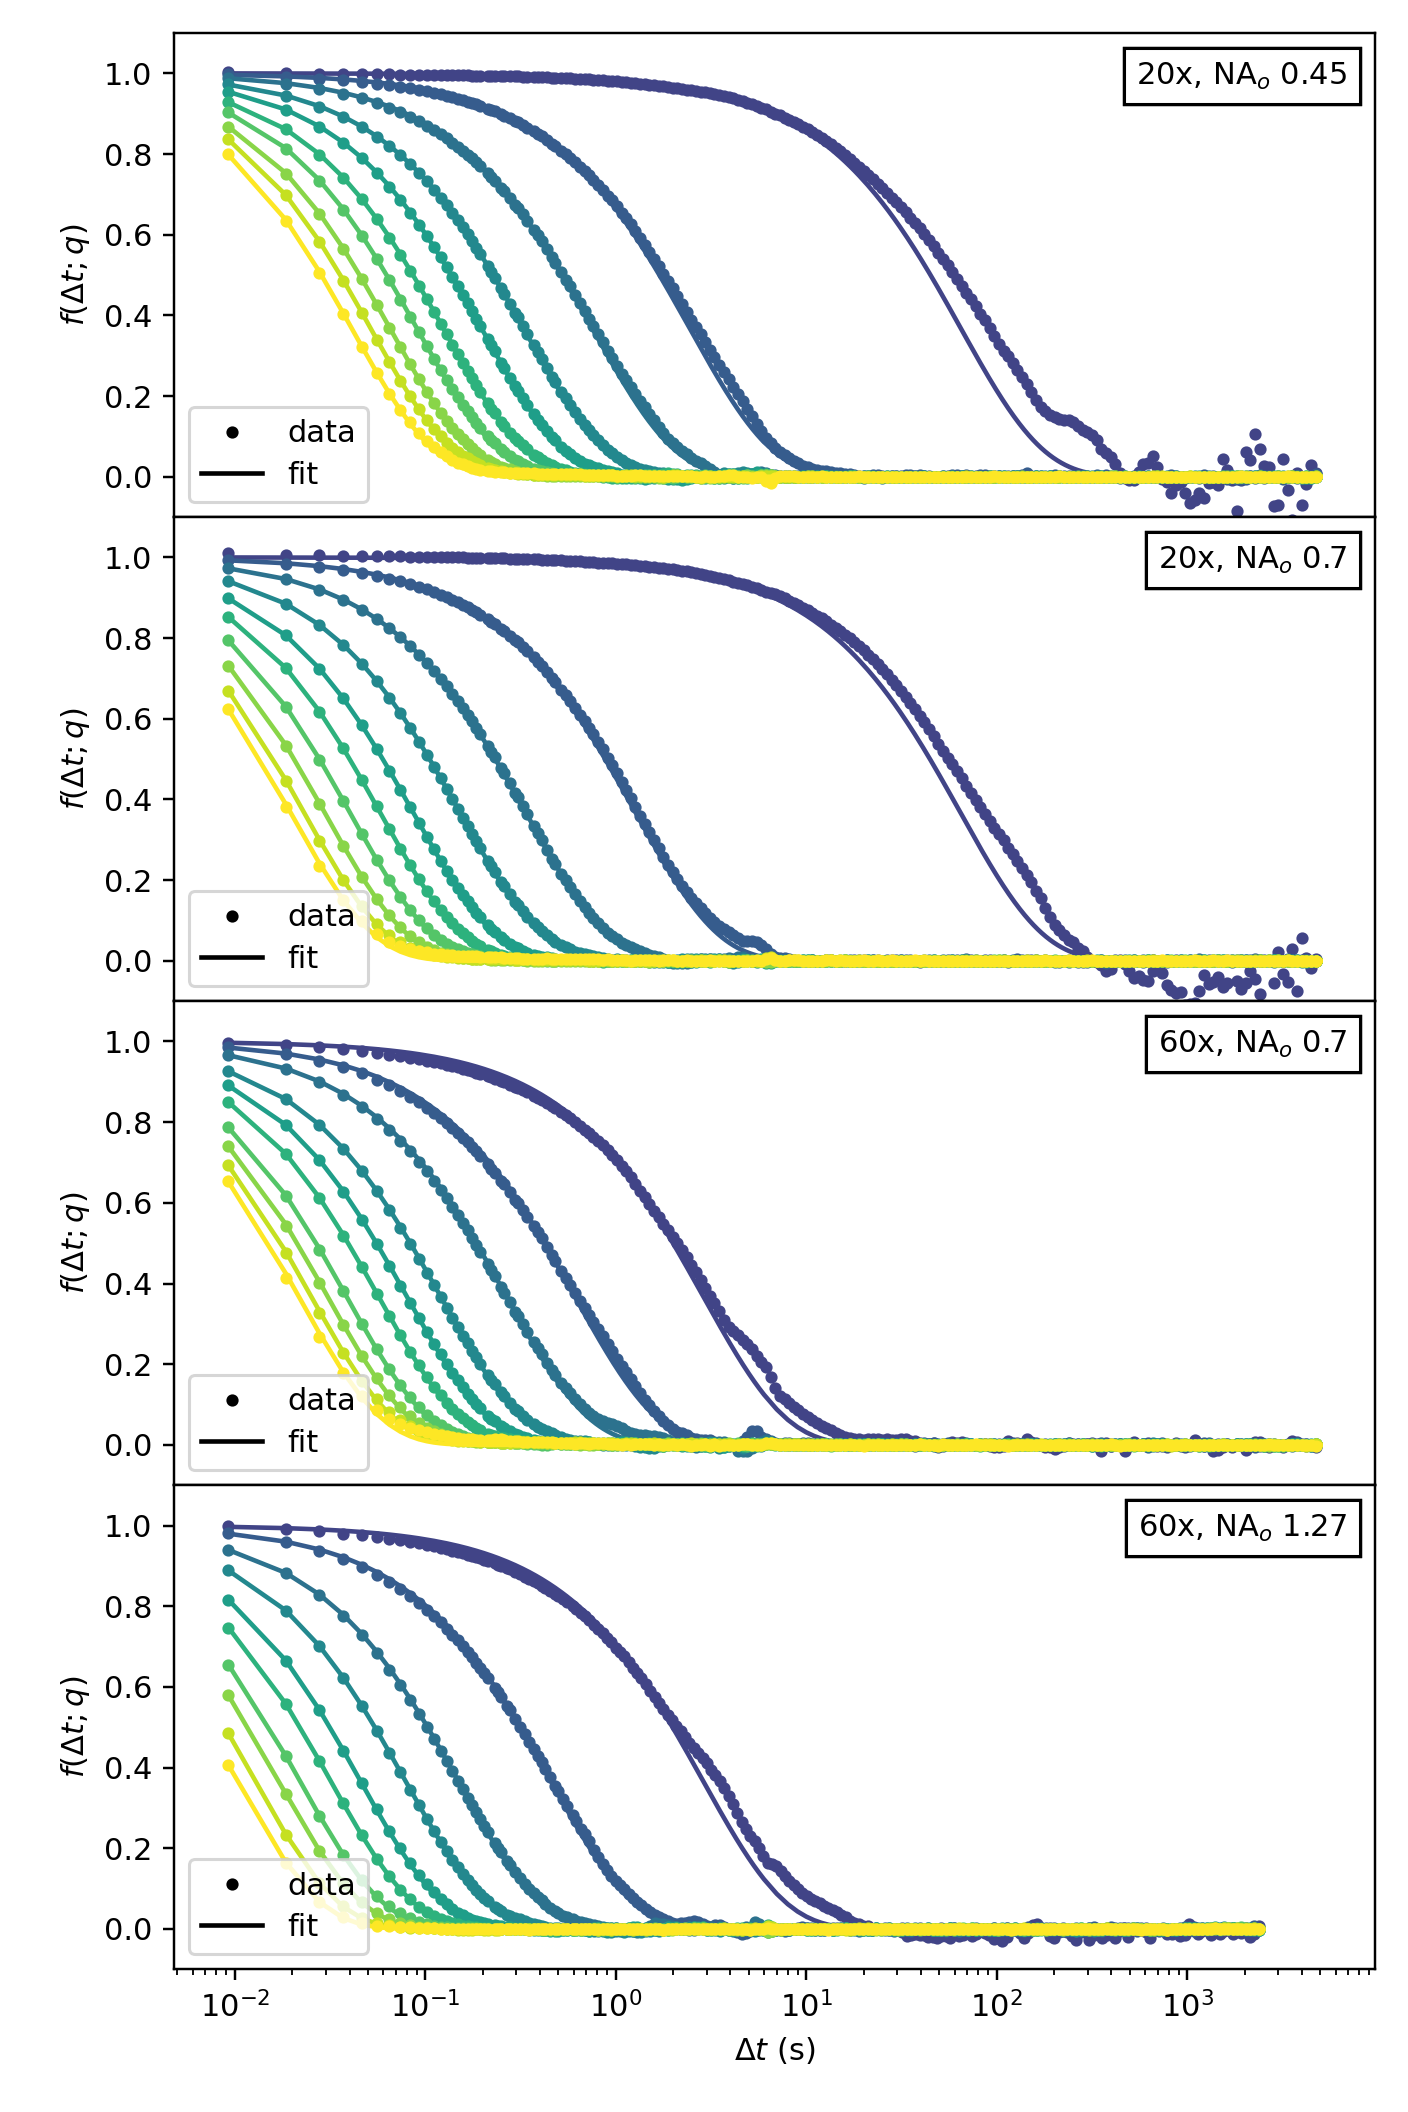

In [12]:
fig = plt.figure()
fig.set_figheight((len(aa) / 2) * fig.get_figheight())
gs = fig.add_gridspec(len(aa), hspace=0)
axs = gs.subplots(sharex=True)

# plot curves
for ax, a, ar, fr, mr, km, kM, l in zip(axs, aa, aa_resampled, fit_res,
                                        model_res, k_min, k_max, labels):
    idx_min = np.argwhere(a.k >= km)[0,0]
    idx_max = np.argwhere(a.k <= kM)[-1,0]
    k_list = np.linspace(idx_min, idx_max, num=10, dtype=int)

    cspace = color_space(len(k_list))
    
    for k_idx, c in zip(k_list, cspace):
        # calculate intermediate scattering function
        fqt = 1 - (ar.data[k_idx] - fr['B'][k_idx]) / fr['A'][k_idx]
        fqt_fit = 1 - (mr[k_idx].best_fit - fr['B'][k_idx]) / fr['A'][k_idx]
    
        # plot
        ax.plot(ar.tau, fqt, '.', color=c)
        ax.plot(a.tau, fqt_fit, '-', color=c)
        
        # misc
        ax.set_ylabel(r'$f(\Delta t; q)$')
        ax.set_ylim(-0.1, 1.1)
        # label
        at = AnchoredText(l, prop=dict(size=10), frameon=True,
                          loc='upper right')
        ax.add_artist(at)
        # custom legend
        custom_lines = [
            Line2D([0], [0], marker='.', linestyle='none', color='black',
                   label='data'),
            Line2D([0], [0], linestyle='-', color='black', label='fit'),
        ]
        ax.legend(handles=custom_lines, labelspacing=0.4, loc='lower left')
        
axs[-1].set_xscale('log')
axs[-1].set_xlabel(r'$\Delta t$ (s)')

fig.tight_layout();

### 2.C. Effect of objective numerical aperture on the output

Finally, we show the fit parameters, $\Gamma$, $A$, and $B$.
We also display the upper limit $q_{\text{max}}$ defined in [tutorial1](../Tutorial_1-Particle_sizing/tutorial1.ipynb).

In [13]:
# optical parameters
L = np.array([256 * ps for ps in pixel_size])
NAo = np.array([0.45, 0.7, 0.7, 1.27])
lambda0 = 0.53

# limits
q_min = 2 * np.pi / L
q_max = 2 * np.pi * NAo / lambda0
gamma_0 = 1 / aa[0].tau[0]    # also, gamma_0 = frame_rate
gamma_T = 1 / aa[0].tau[-1]

<IPython.core.display.Javascript object>


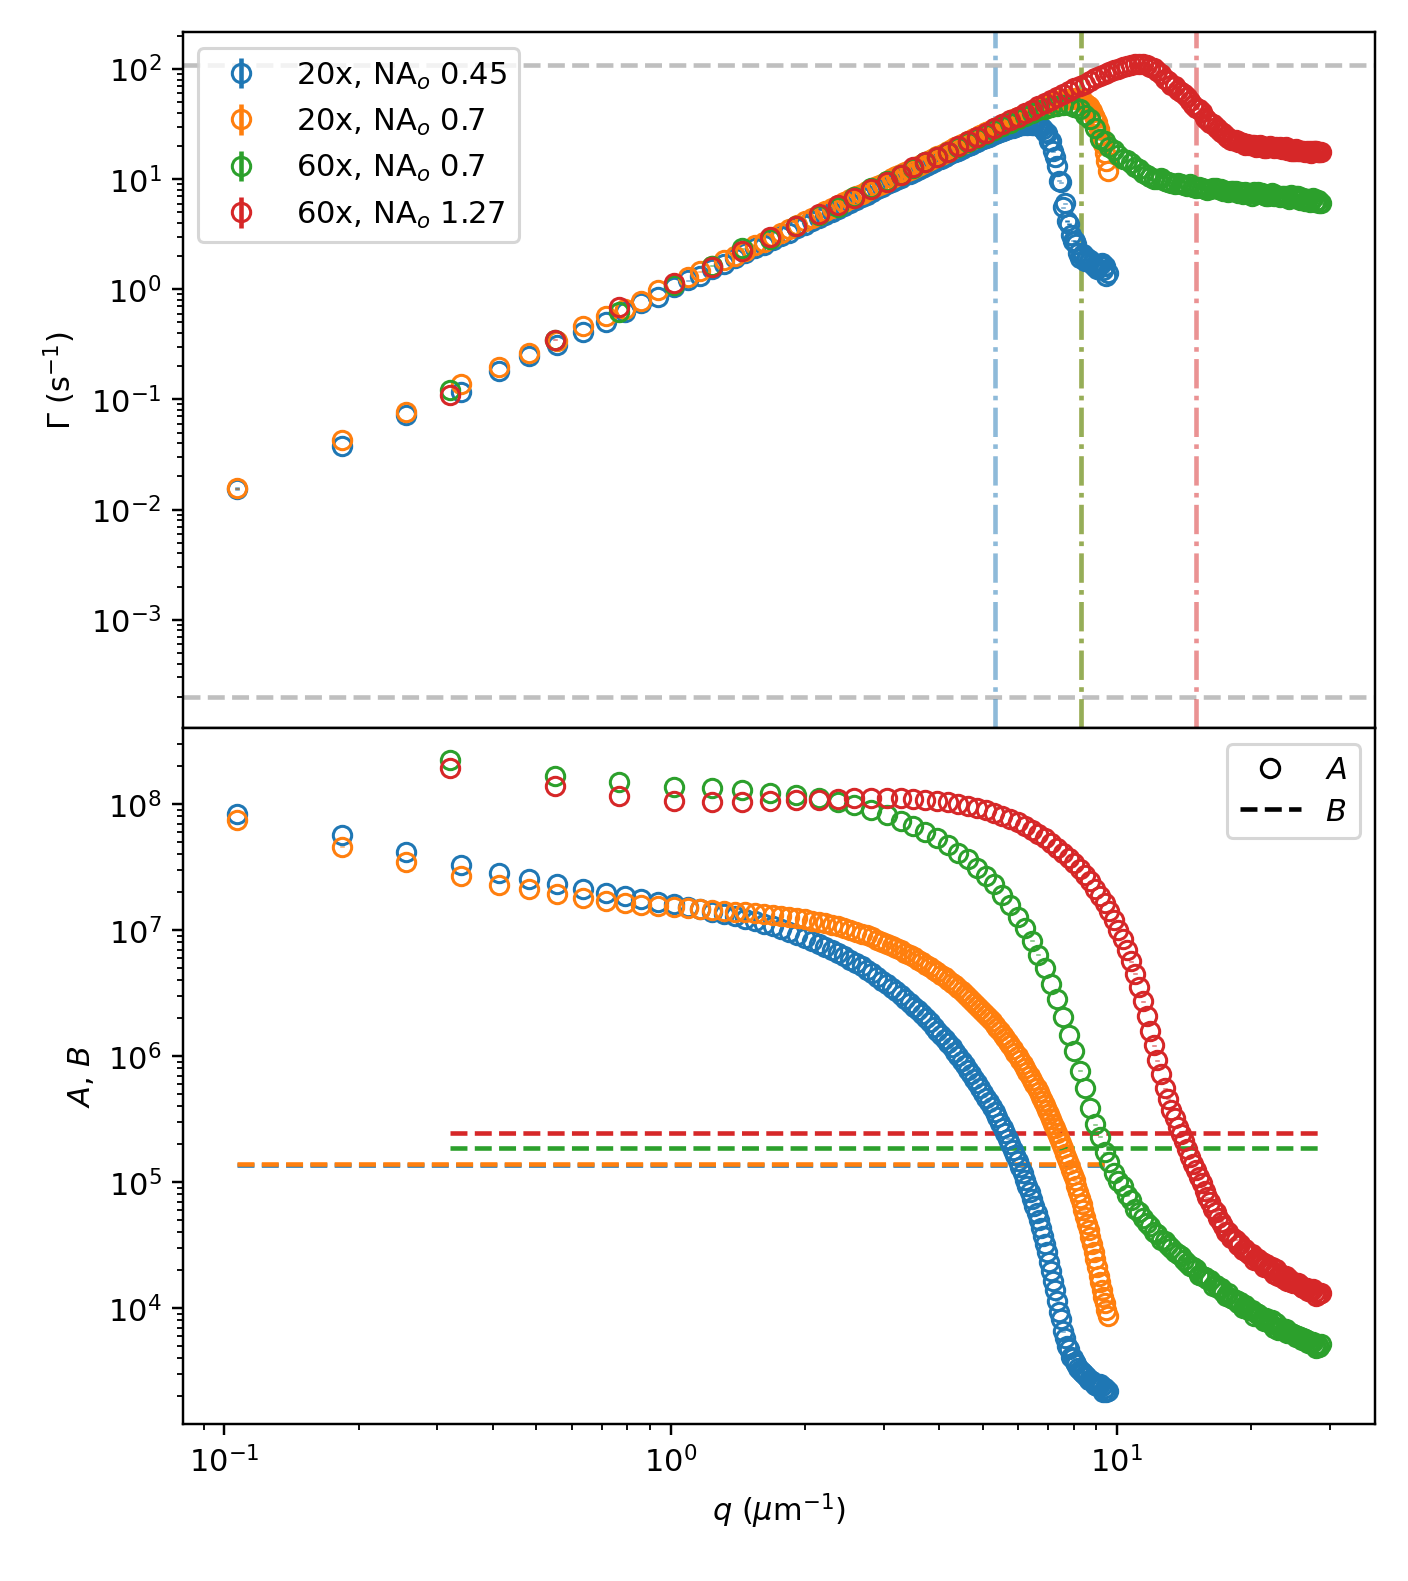

In [14]:
fig = plt.figure()
fig.set_figheight(1.5 * fig.get_figheight())
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)

# plot
for n, (fr, label) in enumerate(zip(fit_res, labels)):
    # filter only nan and non-successful fits
    tmp_df = fr[fr['success']].dropna()
    
    # display the full data (with transparency)
    axs[0].errorbar(
        tmp_df['k'],
        tmp_df['Gamma'],
        yerr=tmp_df['Gamma_stderr'],
        fmt=f'C{n}o',
        markerfacecolor='none',
        label=label
    )
    axs[1].errorbar(
        tmp_df['k'],
        tmp_df['A'],
        yerr=tmp_df['A_stderr'],
        fmt=f'C{n}o',
        markerfacecolor='none',
    )
    axs[1].plot(
        tmp_df['k'],
        np.full_like(tmp_df['B'],
                     fill_value=tmp_df[tmp_df['B']>0]['B'].mean()),
        f'C{n}--',
    )

# settings
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$\Gamma$ (s$^{-1}$)')
axs[0].legend(loc='upper left')
axs[1].set_xscale('log')
axs[1].set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
axs[1].set_yscale('log')
axs[1].set_ylabel(r'$A$, $B$')
custom_lines = [
    Line2D([0], [0], marker='o', linestyle='none', markerfacecolor='none',
           color='black', label=r'$A$'),
    Line2D([0], [0], linestyle='--', color='black', label=r'$B$'),
]
axs[1].legend(handles=custom_lines, labelspacing=0.4, loc='upper right')

# plot Gamma limits
axs[0].axhline(gamma_T, color='gray', linestyle='--', alpha=0.5)
axs[0].axhline(gamma_0, color='gray', linestyle='--', alpha=0.5)

# plot q limits
for n, qM in enumerate(q_max):
    axs[0].axvline(x=qM, color=f'C{n}', linestyle='-.', alpha=0.5)

fig.tight_layout();

The vertical dash-dotted lines in the upper panel are the $q_{\text{max}} = 2 \pi \mathrm{NA}_o / \lambda$ limits for the four objectives.
The effect of the objective numerical aperture is to shift the upper boundary of the $q$ range proportionally to the magnification itself.
Notice that, for the 60$\times$, NA 1.27 objective, the range of measurable relaxation rates is limited by the upper limit $\gamma_0$ (i.e., the frame rate).

We can again filter the fit results as we saw in the first tutorial.

In [15]:
# filter fit results
fit_res_filtered = []

for fr, qm, qM in zip(fit_res, q_min, q_max):
    # remove non-succesful fits and nans
    tmp_df = fr[fr['success']].dropna()
    
    # filter q range
    tmp_df = tmp_df[(tmp_df['k'] >= qm) & (tmp_df['k'] <= qM)]
    
    # we also use gamma_0 to filter out the values at larger q
    # (this for the 60x, NA 1.27 objective)
    k_threshold = tmp_df['k'][tmp_df['Gamma'] > gamma_0].min()
    
    # filter Gamma range
    if not np.isnan(k_threshold):
        tmp_df = tmp_df[tmp_df['k']<k_threshold]
        tmp_df = tmp_df[tmp_df['Gamma']>=gamma_T]
    else:
        tmp_df = tmp_df[
            (tmp_df['Gamma']>=gamma_T) & (tmp_df['Gamma']<=gamma_0)
        ]
    
    # append to list
    fit_res_filtered.append(tmp_df)

<IPython.core.display.Javascript object>


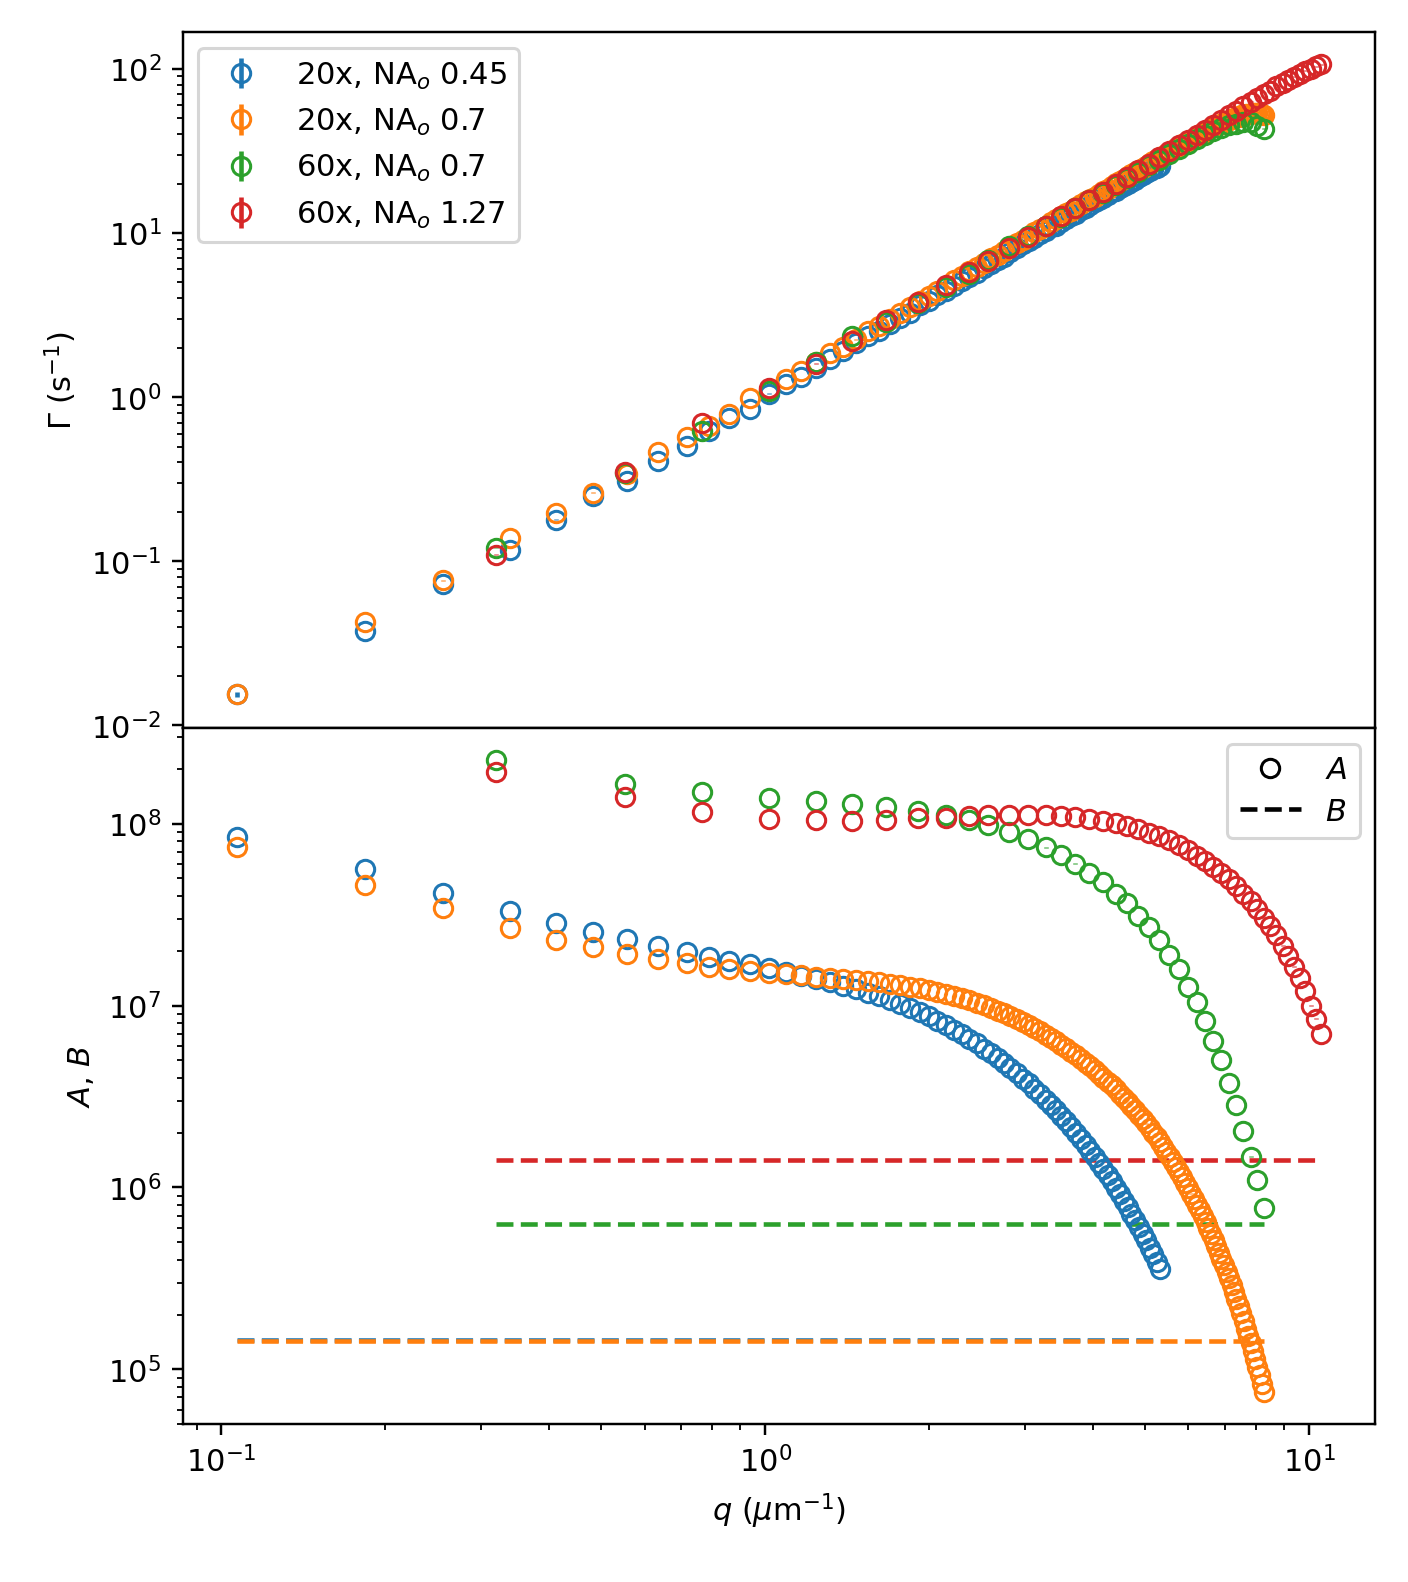

In [16]:
fig = plt.figure()
fig.set_figheight(1.5 * fig.get_figheight())
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)

# plot
for n, (fr, label) in enumerate(zip(fit_res_filtered, labels)):
    
    # display the full data (with transparency)
    axs[0].errorbar(
        fr['k'],
        fr['Gamma'],
        yerr=fr['Gamma_stderr'],
        fmt=f'C{n}o',
        markerfacecolor='none',
        label=label
    )
    axs[1].errorbar(
        fr['k'],
        fr['A'],
        yerr=fr['A_stderr'],
        fmt=f'C{n}o',
        markerfacecolor='none',
    )
    axs[1].plot(
        fr['k'],
        np.full_like(fr['B'], fill_value=fr[fr['B']>0]['B'].mean()),
        f'C{n}--',
    )

# settings
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$\Gamma$ (s$^{-1}$)')
axs[0].legend()
axs[1].set_xscale('log')
axs[1].set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
axs[1].set_yscale('log')
axs[1].set_ylabel(r'$A$, $B$')
custom_lines = [
    Line2D([0], [0], marker='o', linestyle='none', markerfacecolor='none',
           color='black', label=r'$A$'),
    Line2D([0], [0], linestyle='--', color='black', label=r'$B$'),
]
axs[1].legend(handles=custom_lines, labelspacing=0.4, loc='upper right')

fig.tight_layout();

### 2.D. Fit $\Gamma$ to retrieve the diffusion coefficient

For *purely diffusive dynamics*, the relaxation rate and diffusion coefficient $D$ are connected via

$$
\Gamma = D q^2 .
$$
By fitting $\Gamma$ using this power law model, we can extract the diffusion coefficient.

In [17]:
# fit Gamma using Dq^2 model
# we actually fit the logarithm of Gamma, so we define log(Dq^2)
# define model
def log_Dq2(x, D):
    return np.log(D * x**2)
model_Gamma = lmfit.Model(log_Dq2, nan_policy="omit")
model_Gamma.set_param_hint("D", min=0.0, value=1.0)

# fit Gamma
D = []
D_err = []
for fr in fit_res_filtered:
    Gamma_fit_res = fit(model_Gamma,
                        xdata=fr['k'],
                        ydata=np.log(fr['Gamma']),
                        weights=fr['Gamma']/fr['Gamma_stderr'])
    D.append(Gamma_fit_res.params["D"].value)
    D_err.append(Gamma_fit_res.params["D"].stderr)

<IPython.core.display.Javascript object>


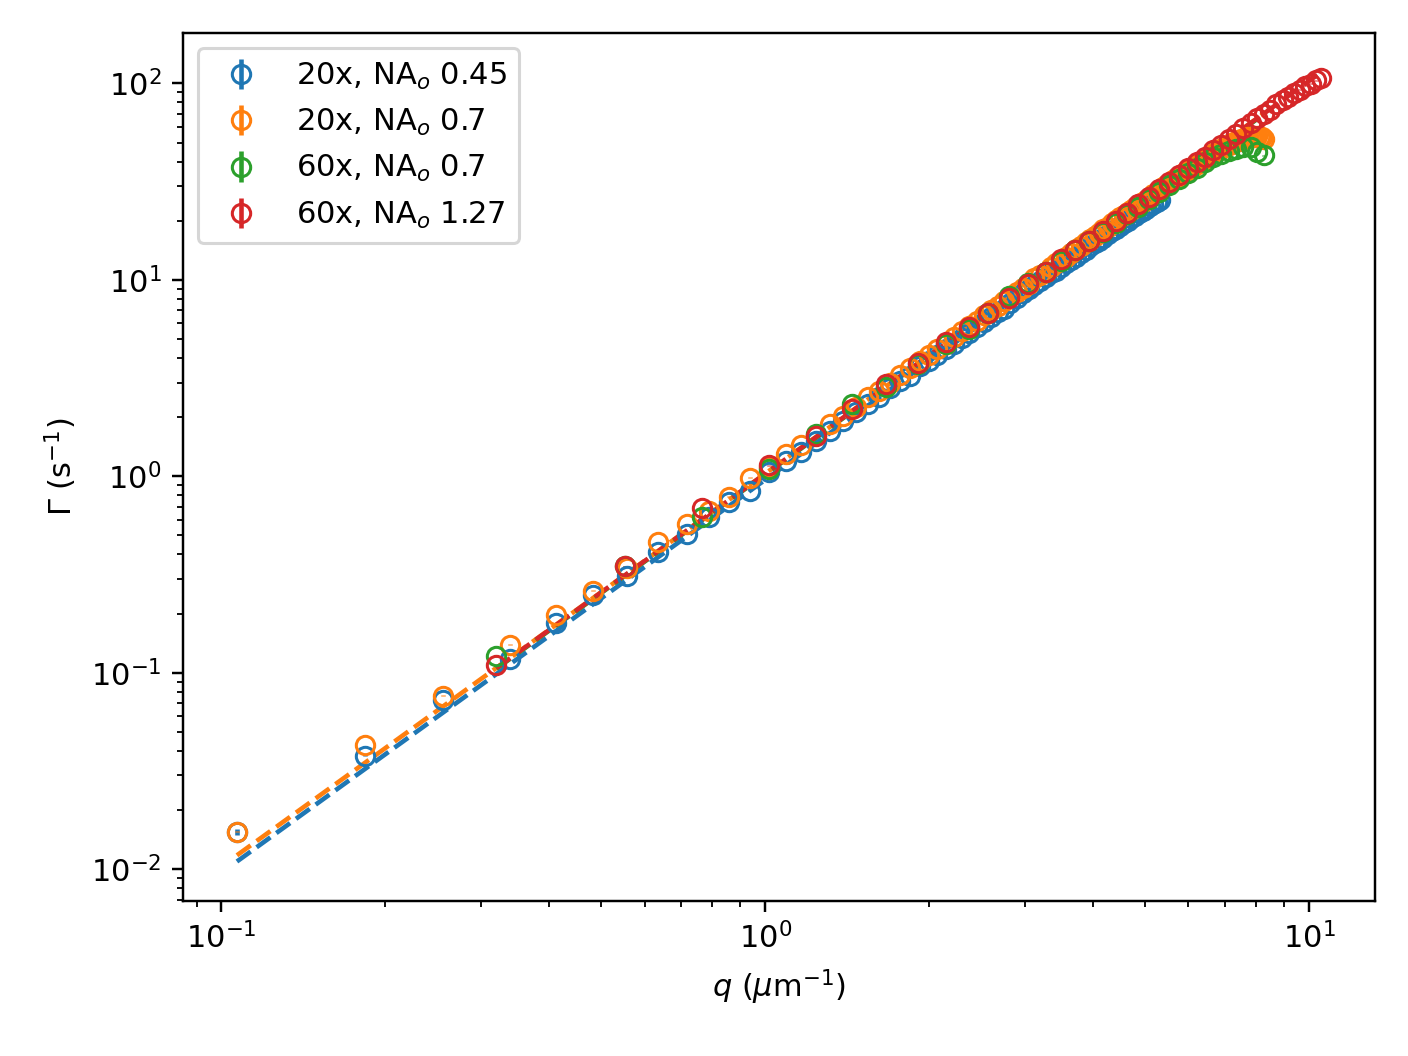

In [18]:
# plot again Gamma with the fit lines
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for n, (frf, label) in enumerate(zip(fit_res_filtered, labels)):
    ax.errorbar(
        frf['k'],
        frf['Gamma'],
        yerr=frf['Gamma_stderr'],
        fmt=f'C{n}o',
        markerfacecolor='none',
        label=label
    )
    ax.plot(
        frf['k'],
        D[n] * frf['k']**2,
        f'C{n}--'
    )

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
ax.set_ylabel(r'$\Gamma$ (s$^{-1}$)')
ax.legend()

fig.tight_layout();

# (\*) Figures for paper

This last section is not part of the tutorial. If you are interested in getting the images used for the particle sizing section of our publication, feel free to set the following flag to `True` and run the cells below. You will need the `scienceplots` package, which is not among the ones required for these tutorials. You can install it through `pip`.

In [19]:
save_figures = False

In [20]:
if save_figures:
    # --- imports ---
    import scienceplots

    plt.style.use(['science', 'nature', 'vibrant'])
    mpl.rcParams['lines.markeredgewidth'] = 0.7
    
    # create FIGS directory
    os.makedirs('FIGS', exist_ok=True)

### Export images

In [21]:
if save_figures:
    # --- save comparison f(q, dt) / fit ---
    fig = plt.figure()
    fig.set_figheight((len(aa) / 2) * fig.get_figheight())
    gs = fig.add_gridspec(len(aa), hspace=0)
    axs = gs.subplots(sharex=True)

    # plot curves
    for ax, a, ar, fr, mr, km, kM, l in zip(axs, aa, aa_resampled, fit_res,
                                            model_res, k_min, k_max, labels):
        idx_min = np.argwhere(a.k >= km)[0,0]
        idx_max = np.argwhere(a.k <= kM)[-1,0]
        k_list = np.linspace(idx_min, idx_max, num=10, dtype=int)

        cspace = color_space(len(k_list))
    
        for k_idx, c in zip(k_list, cspace):
            # calculate intermediate scattering function
            fqt = 1 - (ar.data[k_idx] - fr['B'][k_idx]) / fr['A'][k_idx]
            fqt_fit = ( 1 - \
                       (mr[k_idx].best_fit - fr['B'][k_idx]) / \
                       fr['A'][k_idx] )
    
            # plot
            ax.plot(ar.tau, fqt, '.', color=c)
            ax.plot(a.tau, fqt_fit, '-', color=c)
        
            # misc
            ax.set_ylabel(r'$f(\Delta t; q)$')
            ax.set_ylim(-0.1, 1.1)
            # label
            at = AnchoredText(l, prop=dict(size=10), frameon=True,
                              loc='upper right')
            ax.add_artist(at)
            # custom legend
            custom_lines = [
                Line2D([0], [0], marker='.', linestyle='none',
                       color='black', label='data'),
                Line2D([0], [0], linestyle='-', color='black',
                       label='fit'),
            ]
            ax.legend(handles=custom_lines, labelspacing=0.4,
                      loc='center right')
        
    axs[-1].set_xscale('log')
    axs[-1].set_xlabel(r'$\Delta t$ (s)')

    fig.tight_layout()
    
    fig.savefig('FIGS/fqt.pdf', dpi=600)

In [22]:
if save_figures:
    # --- save fit parameters ---
    fig = plt.figure()
    fig.set_figheight(1.7 * fig.get_figheight())
    gs = fig.add_gridspec(2, hspace=0)
    axs = gs.subplots(sharex=True)
    
    for n, (fr, frf, d, label) in enumerate(zip(fit_res, fit_res_filtered,
                                                D, labels)):
        # plot Gamma
        axs[0].plot(frf['k'], frf['Gamma'],
                    f'C{n}o', markerfacecolor='none',
                    label=label)
        
        # plot fit line
        axs[0].plot(frf['k'], d * frf['k']**2,
                    f'C{n}--')
        
        # plot A
        axs[1].plot(frf['k'], frf['A'],
                    f'C{n}o', markerfacecolor='none')
        
        # plot B
        axs[1].plot(frf['k'],
                    np.full_like(frf['B'],
                                 fill_value=frf[frf['B']>0]['B'].mean()),
                    f'C{n}--')
    
    # plot q_max limit
    for n, qM in enumerate(q_max):
        axs[0].axvline(x=qM, color=f'C{n}', linestyle='-.', alpha=0.8)
        axs[1].axvline(x=qM, color=f'C{n}', linestyle='-.', alpha=0.8)
        
    # plot gamma limit
    axs[0].axhline(gamma_0, color='gray', linestyle='--', alpha=0.8)
    
    # settings
    axs[0].set_yscale('log')
    axs[0].set_ylabel(r'$\Gamma$ (s$^{-1}$)')
    axs[0].legend(loc='lower center')
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
    axs[1].set_ylabel(r'$A$, $B$')
    custom_lines = [
        Line2D([0], [0], marker='o', linestyle='none',
               markerfacecolor='none', color='black', label=r'$A$'),
        Line2D([0], [0], linestyle='--', color='black', label=r'$B$'),
    ]
    axs[1].legend(handles=custom_lines, labelspacing=0.4, loc='center left')
    
    # plot panel label   
    at = [
        AnchoredText("a)", prop=dict(size=10), frameon=False,
                     loc='upper left'),
        AnchoredText("b)", prop=dict(size=10), frameon=False,
                     loc='upper left'),
    ]
    for a, _at in zip(axs, at):
        a.add_artist(_at)
    
    fig.tight_layout()
    
    fig.savefig('FIGS/Gamma_AB.pdf', dpi=600)